In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 13:04:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read in dataset
data = spark.read.csv('Dataset/new_data.csv', header=True, inferSchema=True)

In [3]:
data.printSchema()

root
 |-- Heart Attack Risk (1: Yes): integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Country_indexed: integer (nullable = true)
 |-- Diastolic: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)



## Logistic Regression

In [5]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# Assuming 'data' is your original DataFrame
target_column = "Heart Attack Risk (1: Yes)"
feature_columns = [col for col in data.columns if col != target_column]

# Combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data1 = assembler.transform(data).select("features", target_column)

# Split the assembled data into training and testing sets
train_data, test_data = data1.randomSplit([0.8, 0.2], seed=42)

# Separate features and target for training and testing sets
X_train = train_data.select("features")
y_train = train_data.select(target_column)
X_test = test_data.select("features")
y_test = test_data.select(target_column)

# Show the count of rows in each set
print("X_train count: ", X_train.count())
print("y_train count: ", y_train.count())
print("X_test count: ", X_test.count())
print("y_test count: ", y_test.count())

X_train count:  838
y_train count:  838
X_test count:  162
y_test count:  162


In [6]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import expr

# Fit the Logistic Regression model
lr = LogisticRegression(labelCol=target_column, featuresCol="features")
lr_model = lr.fit(train_data)

# Make predictions on the training and testing sets
train_predictions = lr_model.transform(train_data)
test_predictions = lr_model.transform(test_data)

# Define the evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol=target_column, predictionCol="prediction", metricName="accuracy"
)

# Calculate accuracy scores for training and testing sets
train_accuracy = evaluator.evaluate(train_predictions)
test_accuracy = evaluator.evaluate(test_predictions)

# Print accuracy scores
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")


24/05/23 13:04:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 13:04:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Training Accuracy: 0.55
Testing Accuracy: 0.49


In [7]:
# Extract feature coefficients
coefficients = lr_model.coefficients
intercept = lr_model.intercept

# Convert feature coefficients to a DataFrame for better readability
coefficients_df = spark.createDataFrame(
    [(feature, round(float(coeff), 6)) for feature, coeff in zip(feature_columns, coefficients)],
    ["Feature", "Coefficient"]
)

# Show feature coefficients
coefficients_df.show(truncate=False)


+-----------------------+-----------+
|Feature                |Coefficient|
+-----------------------+-----------+
|Income                 |-1.0E-6    |
|Cholesterol            |0.001431   |
|Country_indexed        |2.9E-5     |
|Diastolic              |-0.004038  |
|Exercise Hours Per Week|-0.007842  |
|Heart Rate             |0.001061   |
|Triglycerides          |-2.17E-4   |
|BMI                    |-0.008633  |
|Sedentary Hours Per Day|0.007461   |
|Age                    |0.006027   |
|Stress Level           |0.03614    |
+-----------------------+-----------+



In [8]:
# Create a cross-tabulation of predicted vs. actual classes for the test set
cross_tab = test_predictions.groupBy("prediction").pivot(target_column).count()

# Display the cross-tabulation
cross_tab.show()

+----------+---+---+
|prediction|  0|  1|
+----------+---+---+
|       0.0| 31| 33|
|       1.0| 50| 48|
+----------+---+---+



## Decision tree

In [9]:
from pyspark.ml.classification import DecisionTreeClassifier

# Fit the Decision Tree model
dt = DecisionTreeClassifier(labelCol=target_column, featuresCol="features")
dt_model = dt.fit(train_data)

# Make predictions on the training and testing sets
train_predictions = dt_model.transform(train_data)
test_predictions = dt_model.transform(test_data)

# Define the evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol=target_column, predictionCol="prediction", metricName="accuracy"
)

# Calculate accuracy scores for training and testing sets
train_accuracy = evaluator.evaluate(train_predictions)
test_accuracy = evaluator.evaluate(test_predictions)

# Print accuracy scores
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.6444
Testing Accuracy: 0.5123


In [10]:
# Produce feature importance values
importances = dt_model.featureImportances
feature_importances = [(feature, round(float(importance), 4)) for feature, importance in zip(feature_columns, importances)]

# Convert feature importances to a DataFrame
importances_df = spark.createDataFrame(feature_importances, ["Feature", "Importance"])
importances_df = importances_df.orderBy(col("Importance").desc())


# Show feature importances
importances_df.show(truncate=False)

+-----------------------+----------+
|Feature                |Importance|
+-----------------------+----------+
|Sedentary Hours Per Day|0.1724    |
|BMI                    |0.1652    |
|Exercise Hours Per Week|0.1141    |
|Triglycerides          |0.1118    |
|Cholesterol            |0.0947    |
|Age                    |0.0927    |
|Country_indexed        |0.0643    |
|Heart Rate             |0.0591    |
|Diastolic              |0.0508    |
|Stress Level           |0.048     |
|Income                 |0.0269    |
+-----------------------+----------+



In [11]:
from pyspark.ml.classification import DecisionTreeClassificationModel

def extract_rules(tree_model):
    # Get the debug string
    tree_debug_string = tree_model._java_obj.toDebugString()

    # Print the debug string for debugging
    print(tree_debug_string)

    # Split the debug string by line and remove empty lines
    lines = filter(None, tree_debug_string.split("\n"))

    # Initialize an empty list to store the rules
    rules = []

    # Iterate through each line in the debug string
    for line in lines:
        # Skip lines that don't represent decision nodes
        if not line.startswith("If") and not line.startswith("Else"):
            continue
        
        # Extract the rule from the line
        rule = line.strip().replace("(", "").replace(")", "").replace("feature ", "").replace("<=", "<=").replace(">", ">").replace(" AND", " and").replace(" OR", " or")
        rules.append(rule)
    
    return rules

# Assuming dt_model is your trained DecisionTreeClassificationModel
rules = extract_rules(dt_model)

# Print the rules
for rule in rules:
    print(rule)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_60ab6c4d29b0, depth=5, numNodes=39, numClasses=2, numFeatures=11
  If (feature 9 <= 67.5)
   If (feature 1 <= 336.5)
    If (feature 8 <= 10.94008116)
     If (feature 3 <= 62.5)
      If (feature 7 <= 35.123803734999996)
       Predict: 1.0
      Else (feature 7 > 35.123803734999996)
       Predict: 0.0
     Else (feature 3 > 62.5)
      Predict: 0.0
    Else (feature 8 > 10.94008116)
     If (feature 4 <= 18.80534069)
      If (feature 9 <= 28.5)
       Predict: 0.0
      Else (feature 9 > 28.5)
       Predict: 1.0
     Else (feature 4 > 18.80534069)
      Predict: 0.0
   Else (feature 1 > 336.5)
    If (feature 6 <= 713.5)
     If (feature 4 <= 2.6698620694999997)
      If (feature 4 <= 0.660914234)
       Predict: 1.0
      Else (feature 4 > 0.660914234)
       Predict: 0.0
     Else (feature 4 > 2.6698620694999997)
      Predict: 1.0
    Else (feature 6 > 713.5)
     Predict: 1.0
  Else (feature 9 > 67.5)
   If (feature 6

In [12]:
# Create a cross-tabulation of predicted vs. actual classes for the test set
cross_tab = test_predictions.groupBy("prediction").pivot(target_column).count()

# Display the cross-tabulation
cross_tab.show()

+----------+---+---+
|prediction|  0|  1|
+----------+---+---+
|       0.0| 40| 38|
|       1.0| 41| 43|
+----------+---+---+



## Association

In [13]:
from pyspark.sql.functions import array, col, concat_ws

# Combine all columns into a single column containing the items for each transaction
data2 = data.withColumn("items", concat_ws(",", *data.columns))

# Select only the items column
transaction_data = data2.select("items")

In [14]:
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import split, array_distinct
from pyspark.sql.functions import col, create_map, lit
from itertools import chain


# Split the concatenated string into an array of items
transaction_data = data2.withColumn("items", split("items", ","))

# Deduplicate the items within each transaction
transaction_data = transaction_data.withColumn("items", array_distinct("items"))

# Create an FPGrowth object
fp_growth = FPGrowth(itemsCol="items", minSupport=0.1, minConfidence=0.1)

# Fit the FPGrowth model
model = fp_growth.fit(transaction_data)

# Get the frequent itemsets
frequent_itemsets = model.freqItemsets

# Get the association rules
association_rules = model.associationRules

# Define a mapping dictionary for feature names
feature_map = {
    0: "Heart Attack Risk (1: Yes)",
    1: "Income",
    2: "Cholesterol",
    3: "Country_indexed",
    4: "Diastolic",
    5: "Exercise Hours Per Week",
    6: "Heart Rate",
    7: "Triglycerides",
    8: "BMI",
    9: "Sedentary Hours Per Day",
    10: "Age",
    11: "Stress Level",
}

# Convert the mapping dictionary to a Spark DataFrame column
mapping_expr = create_map([lit(x) for x in chain(*feature_map.items())])

# Apply the mapping to the antecedent and consequent columns
association_rules_mapped = association_rules.withColumn(
    "antecedent_feature", mapping_expr.getItem(col("antecedent")[0])
).withColumn(
    "consequent_feature", mapping_expr.getItem(col("consequent")[0])
).drop("antecedent", "consequent")

# Show the association rules with feature names
association_rules_mapped.show(truncate=False)



/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/column.py:322: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+-------------------+-------------------+-------+--------------------------+--------------------------+
|confidence         |lift               |support|antecedent_feature        |consequent_feature        |
+-------------------+-------------------+-------+--------------------------+--------------------------+
|0.20342205323193915|0.3501240158897404 |0.107  |Heart Attack Risk (1: Yes)|Income                    |
|0.6024096385542169 |1.036849636065778  |0.1    |Heart Rate                |Income                    |
|0.1721170395869191 |1.0368496360657777 |0.1    |Income                    |Heart Rate                |
|0.18416523235800344|0.35012401588974035|0.107  |Income                    |Heart Attack Risk (1: Yes)|
+-------------------+-------------------+-------+--------------------------+--------------------------+



## Two-Step Clustering

In [17]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Define your clustering model
kmeans = KMeans().setK(3).setSeed(42)  # Example: 3 clusters, seed for reproducibility

# Pipeline to assemble features and fit KMeans model
pipeline1 = Pipeline(stages=[assembler, kmeans])

train_data1, test_data1 = data.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline to the train data
model1 = pipeline1.fit(train_data1)

# Make predictions on both train and test data
train_predictions1 = model1.transform(train_data1)
test_predictions1 = model1.transform(test_data1)

# Evaluate clustering performance using silhouette score
evaluator = ClusteringEvaluator()

# Compute silhouette score for train data
train_silhouette_score = evaluator.evaluate(train_predictions1)
print("Silhouette Score for Train Data:", train_silhouette_score)

# Compute silhouette score for test data
test_silhouette_score = evaluator.evaluate(test_predictions1)
print("Silhouette Score for Test Data:", test_silhouette_score)

Silhouette Score for Train Data: 0.7501455549984403
Silhouette Score for Test Data: 0.763603385563619


Silhouette Score: 0.7534453958119569


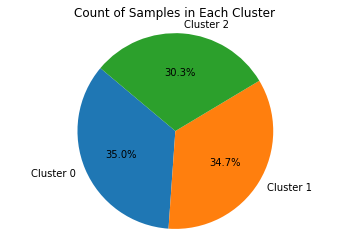

In [18]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

# Fit KMeans model
kmeans = KMeans().setK(3).setSeed(42)  # 3 clusters, seed for reproducibility
pipeline = Pipeline(stages=[assembler, kmeans])
model = pipeline.fit(data)

# Make predictions
predictions = model.transform(data)

# Evaluate clustering performance using silhouette score
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)
print("Silhouette Score:", silhouette_score)

# Get count of samples in each cluster
cluster_counts = predictions.groupBy('prediction').count().orderBy('prediction').collect()

# Plot count of samples in each cluster
labels = [f"Cluster {row['prediction']}" for row in cluster_counts]
sizes = [row['count'] for row in cluster_counts]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Count of Samples in Each Cluster')
plt.show()


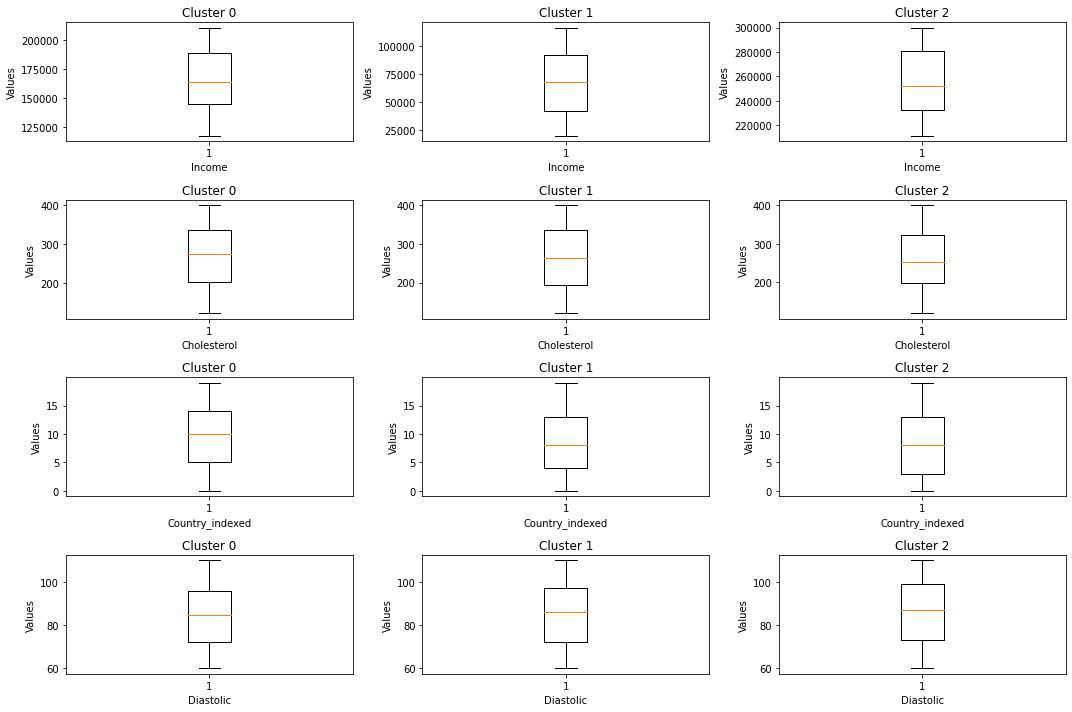

In [19]:
# Draw boxplot for each variable in each cluster (showing only the first 4 features)
num_clusters = 3  # Assuming 3 clusters
num_features = 4  # Show boxplots for the first 4 features
fig, axes = plt.subplots(num_features, num_clusters, figsize=(15, 10))


# Select only the first 4 features
feature_columns_subset = feature_columns[:num_features]

for i, feature in enumerate(feature_columns_subset):
    for j in range(num_clusters):
        cluster_data = predictions.filter(predictions["prediction"] == j).select(feature)
        cluster_values = [row[feature] for row in cluster_data.collect()]
        axes[i, j].boxplot(cluster_values)
        axes[i, j].set_title(f'Cluster {j}')
        axes[i, j].set_xlabel(feature)
        axes[i, j].set_ylabel('Values')

plt.tight_layout()
plt.show()